<a href="https://colab.research.google.com/github/divadde/computer_vision_project/blob/main/progettinoV4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparazione del dataset


Come primo passo, importo tutte le librerie che sono necessarie per la realizzazione del task.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.tv_tensors import BoundingBoxes, BoundingBoxFormat, Mask
from torchvision.transforms.v2 import ConvertBoundingBoxFormat
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import random
import pycocotools
from pycocotools import mask
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from google.colab import drive
from collections import defaultdict

Scrivo una funzione ausiliaria che verrà utilizzata all'interno del dataset custom per l'estrazione e la creazione delle labels in un formato adatto al training del modello. Si può osservare dal file json delle etichette, che il formato delle box è del tipo XYWH, è il caso di portarlo a XYXY per l'addestramento.


In [2]:
def createLabels(json_file):
  data = json_file['annotations']
  grouped_data = defaultdict(list)

  [grouped_data[k['image_id']].append(k) for k in data]

  result_dict = dict(grouped_data)

  ret_dict = {}
  image_id = 0
  for image in result_dict.values():
    bbox = []
    seg = []
    cls = []
    for obj in image:
      image_id = obj['image_id']
      seg.append(mask.decode(mask.merge(mask.frPyObjects(obj['segmentation'],700,700))))
      b = obj['bbox']
      #print(b)
      #controllo se ci sono boxes degenerate
      if b[2]==0: b[2]=b[2]+0.1
      if b[3]==0: b[3]=b[3]+0.1
      box = [b[0],b[1],b[2],b[3]] #formato XYWH
      bbox.append(box)
      cls.append(obj['category_id']+1) #la prima classe non deve avere id 0.
    boundy_box = torchvision.tv_tensors.BoundingBoxes(data=np.array(bbox),format = BoundingBoxFormat.XYWH, canvas_size=(700, 700))
    converter = torchvision.transforms.v2.ConvertBoundingBoxFormat("XYXY")
    final_box = converter._transform(boundy_box, {})
    print(image_id)
    ret_dict[image_id] = {
        'boxes': final_box,
        'labels': torch.tensor(cls, dtype = torch.int64),
        'image_id': obj['image_id'],
        'area': torch.tensor(obj['area'], dtype=torch.float64),
        'iscrowd': torch.tensor(obj['iscrowd'], dtype=torch.uint8),
        'masks': Mask(seg)
    }

  return ret_dict

In [3]:
class TTPLADataset(torch.utils.data.Dataset): #cambia nome alla classe
  def __init__(self,img_dir,labels_dir):
    self.img_dir = img_dir
    self.labels_json = json.load(open(labels_dir)) #apertura del file json delle etichette
    self.image_labels = createLabels(self.labels_json)
    self.categories = {category['name']: category['id'] for category in self.labels_json['categories']} #serve questo attributo "categories"?

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.labels_json['images'][idx]['file_name'])
    image = (torchvision.io.read_image(img_path)/255)
    label = self.image_labels[idx]
    return (image,label)

  def __len__(self):
    return len(os.listdir(self.img_dir))


Carico il dataset di training attraverso il montaggio con Google Drive e sfrutto il dataset custom che ho scritto.

In [4]:
drive.mount('/content/drive',force_remount=True)

#caricamento dei dataset di train e di test
train_set = TTPLADataset('/content/drive/MyDrive/trainingset', '/content/drive/MyDrive/train.json')
#test_set = TTPLADataset('/content/drive/MyDrive/testset', '/content/drive/MyDrive/test.json')

Mounted at /content/drive
0


/usr/local/lib/python3.10/dist-packages/torchvision/tv_tensors/_tv_tensor.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.as_tensor(data, dtype=dtype, device=device).requires_grad_(requires_grad)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [15]:
## PROVE ##

#json_file = json.load(open("/content/drive/MyDrive/train.json")) #apertura del file json delle etichette
#image_labels = createLabels(json_file)
#print(image_labels[0])
#print(image_labels[0])
#print(formatLabels(image_labels[0]))

#box = [0,2,0,3]
#print(box[2:])

[0, 3]


#Training della Mask-RCNN

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#from torchvision.models import ResNet50_Weights

#model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(num_classes=5, weights_backbone=ResNet50_Weights.IMAGENET1K_V2) #provo con quest'altra versione della mask

#model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_V2_Weights) #modello migliore (deve essere addestrato)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
in_features_box = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=5) #una classe è per il background

per poter caricare il modello:

In [8]:
model = torch.load('/content/drive/MyDrive/mask_rcnn_res152_40ep')
#model.to(device)

In [32]:
learning_rate = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, collate_fn= collate_fn)
total_step = len(train_dataloader)

num_epochs = 60

train_losses = []
train_counter = []

def train(epoch,model,optimizer):
    loss_per_epoch = 0
    counter=0
    for batch_idx, (images, targets) in enumerate(train_dataloader):

        counter = counter + 1
        images = [image.to(device) for image in images]
        targets = [{
                    'boxes': target['boxes'].to(device),
                    'labels': target['labels'].to(device),
                    'image_id': target['image_id'],
                    'area': target['area'].to(device),
                    'iscrowd':target['boxes'].to(device),
                    'masks': target['masks'].to(device)
                    } for target in targets]

        # Forward pass
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        #print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        loss_per_epoch = loss_per_epoch + losses

        # Backward pass
        losses.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        if (batch_idx+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, losses))

        if counter==total_step:
          med_loss = loss_per_epoch/counter
          print('Loss media: {}'.format(med_loss))
          counter=0
          loss_per_epoch=0

        train_losses.append(losses)
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(train_dataloader)))

In [33]:
model.train()
model.to(device)

for epoch in range(41,num_epochs+1):
  train(epoch = epoch, model = model, optimizer = optimizer)
  if (epoch%2==0):
    torch.save(model, '/content/drive/MyDrive/mask_rcnn_res152_{}ep'.format(epoch))

Epoch [41/60], Step [1/53], Loss: 0.4781
Epoch [41/60], Step [2/53], Loss: 0.7667
Epoch [41/60], Step [3/53], Loss: 0.7254
Epoch [41/60], Step [4/53], Loss: 0.6987
Epoch [41/60], Step [5/53], Loss: 0.7917
Epoch [41/60], Step [6/53], Loss: 0.6758
Epoch [41/60], Step [7/53], Loss: 0.7838
Epoch [41/60], Step [8/53], Loss: 0.8180


OutOfMemoryError: ignored

# Testing della MASK-RCNN

Questa sezione deve essere inserita in un notebook a parte

In [ ]:
test_set = TTPLADataset('/content/drive/MyDrive/testset', '/content/drive/MyDrive/test.json')

In [27]:
#test_set = TTPLADataset('/content/drive/MyDrive/testset', '/content/drive/MyDrive/test.json')

THRESHOLD_SEGM = 0.5
model.eval()
batch_size = 1
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)

results = []
for images, labels in test_dataloader:

  images = [image.to(device) for image in images]
  prediction = model(images)[0]
  classes = prediction['labels'].cpu().numpy()
  scores = prediction['scores'].cpu().detach().numpy()
  boxes = prediction['boxes'].view(-1,4).cpu().detach().numpy()
  masks = torch.where(prediction['masks'].view(-1,700,700).cpu().detach()>THRESHOLD_SEGM,1,0).numpy()
  for i in range(masks.shape[0]): #per ogni oggetto identificato
    image_id = labels[0]['image_id']
    bbox = boxes[i]
    bbox = [bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1]]
    bbox = [round(float(x)*10)/10 for x in bbox]
    rle = pycocotools.mask.encode(np.asfortranarray(masks[i].astype(np.uint8)))
    rle['counts'] = rle['counts'].decode('ascii')
    results.append({
                'image_id': int(image_id),
                'category_id': int(classes[i])-1,
                'bbox': bbox,
                'segmentation': rle,
                'score': float(scores[i]),
            })

  torch.cuda.empty_cache()
with open('/content/drive/MyDrive/pred.json', 'w') as fp: #salvataggio del json di predizione sul drive
    json.dump(results, fp)

In [28]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
test = '/content/drive/MyDrive/test.json'
pred = '/content/drive/MyDrive/pred.json'
gt = COCO(test)
detections = gt.loadRes(pred)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!


In [29]:
imgIds=sorted(gt.getImgIds())
#imgIds=imgIds[0:100]
#imgId = imgIds[np.random.randint(100)]

In [30]:
annType = 'bbox'
cocoEval = COCOeval(gt, detections, annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.36s).
Accumulating evaluation results...
DONE (t=0.27s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [31]:
annType = 'segm'
cocoEval = COCOeval(gt, detections, annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=4.13s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [61]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
def visualize(img, model, view_boxes = True, view_masks = True):
  prediction = model([img])
  im = torch.tensor((img*255).cpu().numpy().astype(np.uint8),dtype=torch.uint8)
  result = im
  if view_boxes:
    result = draw_bounding_boxes(image=im,boxes=prediction[0]['boxes'],width=3)
  if view_masks:
    masks=torch.squeeze(prediction[0]['masks'])
    masks = torch.where(masks>0.5,True,False)
    result = draw_segmentation_masks(image = result,masks=masks,alpha=0.5)
  return result

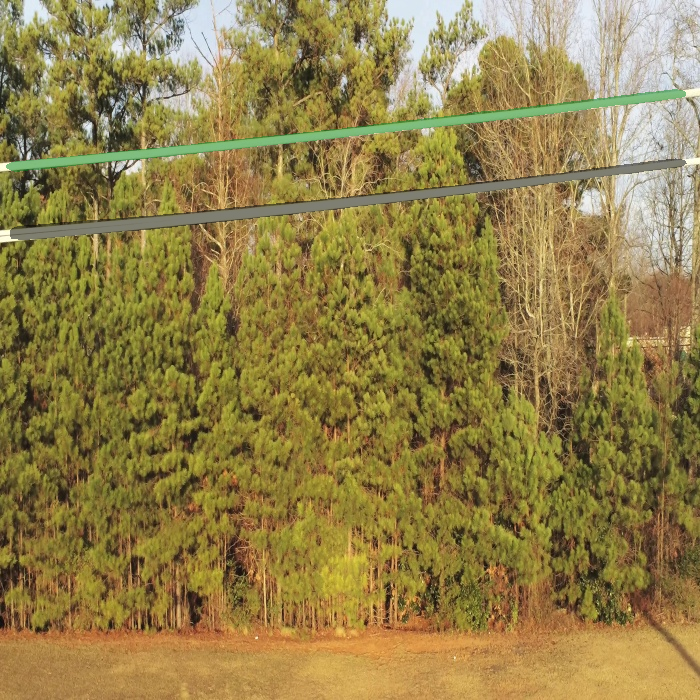

In [64]:
model.eval()
i = np.random.randint(0,len(train_set)-1)
r = visualize(train_set[i][0].to(device),model, view_boxes=False)
torchvision.transforms.ToPILImage()(r)

# Prova RESNET152 come backbone

In [32]:
from torchvision.models.detection import mask_rcnn, backbone_utils
from torchvision.models.detection.faster_rcnn import RPNHead
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.resnet import resnet152
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers


backbone = resnet152(weights=torchvision.models.ResNet152_Weights)
backbone = _resnet_fpn_extractor(backbone, 0)

#print(backbone)

model = mask_rcnn.MaskRCNN(backbone=backbone, num_classes=5) #rpn_head=rpn_head #si potrebbe implementare come testa di segmentazione deeplab

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#***CODICI DI PROVA***

provo a modificare i blocchi che costituiscono la maskrcnn

In [74]:
class RegionProposalNetwork(nn.Module):
    def __init__(self,in_channels = 512, mid_channels = 512, n_anchor = 9):
        super(RegionProposalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        nn.init.normal_(self.conv1.weight, mean=0, std=0.001)
        nn.init.zeros_(self.conv1.bias)

        self.reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
        nn.init.normal_(self.reg_layer.weight, mean=0, std=0.001)
        nn.init.zeros_(self.reg_layer.bias)

        self.cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0)
        nn.init.normal_(self.cls_layer.weight, mean=0, std=0.001)
        nn.init.zeros_(self.cls_layer.bias)


    def forward(self, x):
        x = self.conv1(x)
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)

        pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()

        pred_cls_scores  = pred_cls_scores.view(pred_cls_scores.shape[0], -1, 2)

        return pred_anchor_locs, pred_cls_scores

In [77]:
from torchvision.models import ViT_B_16_Weights
from torchvision.models.feature_extraction import create_feature_extractor

#vit = torchvision.models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1, image_size=700)
#network = getattr(vit)

network = getattr(torchvision.models,"vit_b_16")(pretrained=True)

#print(network)
#print(torchvision.models.feature_extraction.get_graph_node_names(network))

feature_extractor = create_feature_extractor(network, return_nodes=['getitem_5'])

#print(feature_extractor)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Module(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Module(
      (encoder_layer_0): Module(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): Module(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): Multih

In [105]:
from torchvision.models.detection import mask_rcnn, backbone_utils
from torchvision.models.detection.faster_rcnn import RPNHead
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.resnet import resnet50
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers



class VitBackbone(nn.Module):
  def __init__(self,feature_extractor):
    super(VitBackbone,self).__init__()
    self.feature_extractor=feature_extractor

  def forward(self,x):
    return nn.Unflatten(dim=1,unflattened_size=torch.Size([256,3]))(feature_extractor(x)['getitem_5'])

model_backbone = nn.Sequential(nn.Sequential(torchvision.transforms.Resize((224,224)), VitBackbone(feature_extractor)))
#print(model_backbone) <---

backbone_vit = backbone_utils.BackboneWithFPN(backbone=model_backbone, return_layers={'0':'features'}, in_channels_list=[768], out_channels=256)

#print(backbone)

#print(rpn_head)

backbone = resnet50()
#trainable_backbone_layers =
backbone = _resnet_fpn_extractor(backbone, 3)

print("BACKBONE RESNET")
print(backbone)
print("BACKBONE VIT")
print(backbone_vit)

model = mask_rcnn.MaskRCNN(backbone=backbone_vit, num_classes=5) #rpn_head=rpn_head #si potrebbe implementare come testa di segmentazione deeplab

BACKBONE RESNET
BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      

In [106]:
image = torch.randn((1,3,700,700))
#print(image.shape[2])
model.eval()

#grid size
#print([feature_map.shape[-2:] for feature_map in model_backbone(image)])

#image size
#print(image.shape[-2:])

#strides

#cell anchor

#model_backbone(image)
backbone_vit(image)
#model(image)

RuntimeError: ignored

#**LOSS FUNCTIONS**

In [ ]:
class CustomLossFunction(nn.Module):
  def __init__(self, cls_loss, bb_loss, seg_loss, cls_weight, bb_weight, seg_weight):
    super(CustomLossFunction, self).__init__()
    self.cls_loss = cls_loss
    self.bb_loss = bb_loss
    self.seg_loss = seg_loss
    self.cls_weight = cls_weight
    self.bb_weight = bb_weight
    self.seg_weight = seg_weight
  def forward(self,predictions, targets):
    prediction = predictions[0]
    formatted_targets = formatLabels(targets)
    #loss di classificazione
    #scores di classificazione: uno per ogni oggetto predetto
    targets_cls = formatted_targets['labels']
    pred_cls = prediction['scores']
    loss_cls = self.cls_loss(pred_cls,targets_cls)
    #loss di bbox
    targets_bbox = formatted_targets['boxes']
    pred_bbox = prediction['boxes']
    loss_bbox = self.bb_loss(pred_bbox,targets_bbox)
    #loss per le maschere: sigmoide su tutti i pixel e poi cross entropy
    targets_masks = formatted_targets['masks']
    pred_masks = prediction['masks']
    loss_masks = self.seg_loss(pred_masks,targets_masks)

    return self.cls_weight*loss_cls + self.bb_weight*loss_bbox + self.seg_weight*loss_masks

# Detectron

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15292, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 15292 (delta 3), reused 6 (delta 1), pack-reused 15275
Receiving objects: 100% (15292/15292), 6.18 MiB | 6.19 MiB/s, done.
Resolving deltas: 100% (11114/11114), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Prep

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [ ]:
#import vari
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train_set", {}, TRAIN_LABELS, TRAIN_DIR)
register_coco_instances("test_set",{},TEST_LABELS, TEST_DIR)


In [ ]:
train_metadata = MetadataCatalog.get("train_set")
train_dataset_dicts = DatasetCatalog.get("train_set")
test_metadata = MetadataCatalog.get("test_set")
test_dataset_dicts = DatasetCatalog.get("test_set")

WARNING [12/19 12:24:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/19 12:24:57 d2.data.datasets.coco]: Loaded 842 images in COCO format from /content/drive/MyDrive/train.json
WARNING [12/19 12:24:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/19 12:24:57 d2.data.datasets.coco]: Loaded 400 images in COCO format from /content/drive/MyDrive/test.json


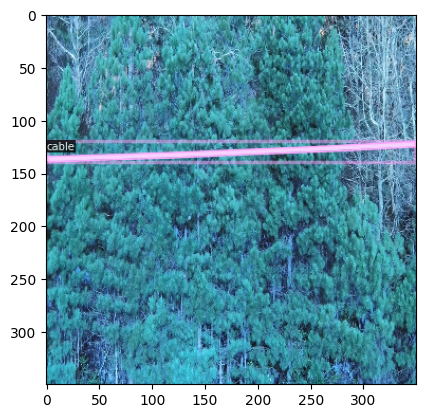

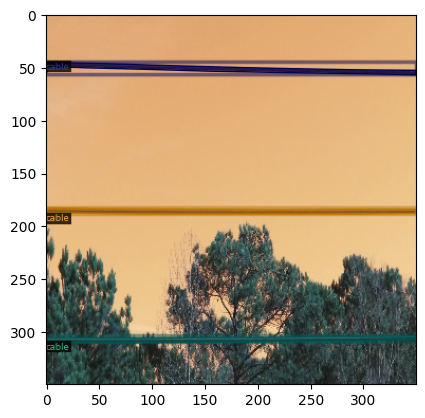

In [ ]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
!pip install light-the-torch
!ltt install torch torchvision

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = '/content/drive/MyDrive/Models/Detectron2/LVIS_X101_pt2'
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("LVISv0.5-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("train_set")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = ('/content/drive/MyDrive/Models/Detectron2/LVIS_X101_pt2/model_final.pth')  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = ('/content/drive/MyDrive/Models/Detectron2/LVIS_X101_pt2/model_final.pth')  # Let training initialize from model zoo
cfg.SOLVER.CHECKPOINT_PERIOD = 1250
cfg.SOLVER.IMS_PER_BATCH = 4  # volevo provare con 32 ma agg finit e metar
cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 2500    #3331
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #oppure 5? #len(MetadataCatalog.get("my_dataset").thing_classes)=4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False)
#MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES = EPOCH

[12/19 09:55:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
#start training
trainer.train()

[12/17 18:46:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/17 18:47:10 d2.utils.events]:  eta: 2:56:16  iter: 19  total_loss: 0.4499  loss_cls: 0.08119  loss_box_reg: 0.1724  loss_mask: 0.08666  loss_rpn_cls: 0.01451  loss_rpn_loc: 0.1287    time: 2.1274  last_time: 2.2472  data_time: 0.0493  last_data_time: 0.0095   lr: 1.9981e-06  max_mem: 7433M
[12/17 18:47:57 d2.utils.events]:  eta: 3:03:38  iter: 39  total_loss: 0.4427  loss_cls: 0.072  loss_box_reg: 0.1714  loss_mask: 0.07838  loss_rpn_cls: 0.01008  loss_rpn_loc: 0.09805    time: 2.1804  last_time: 2.2868  data_time: 0.0093  last_data_time: 0.0094   lr: 3.9961e-06  max_mem: 7433M
[12/17 18:48:46 d2.utils.events]:  eta: 3:08:16  iter: 59  total_loss: 0.5847  loss_cls: 0.09271  loss_box_reg: 0.2  loss_mask: 0.1011  loss_rpn_cls: 0.0236  loss_rpn_loc: 0.1213    time: 2.2751  last_time: 2.5655  data_time: 0.0098  last_data_time: 0.0098   lr: 5.9941e-06  max_mem: 7506M
[12/17 18:49:34 d2.utils.events]:  eta: 3:09:26  iter: 79  total_loss: 0.4483  loss_cls: 0.07378  loss_box_reg: 0.1706  l

In [ ]:
#torch.save(trainer.model, '/content/drive/MyDrive/Models')

RuntimeError: ignored

In [ ]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/Models/Detectron2/LVIS1.0_X101/configX101.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/19 09:04:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Models/Detectron2/LVIS_X101_pt2/model_final.pth ...


Verifica grafica per modelli detectron:

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 1):    #numero di img sul display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels.
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Verifica grafica per modelli pytorch (c'è il problema di mismatch con le etichette, quindi lancia errore se trova wooden tower):

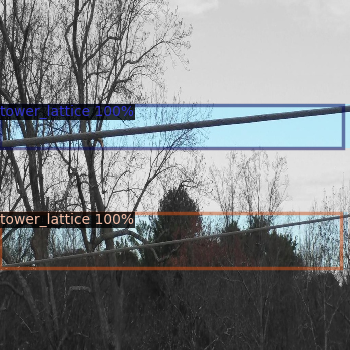

In [ ]:
#CODICE MODIFICATO PER VERIFICARE COL MODELLO DI PYTORCH
from detectron2.utils.visualizer import ColorMode
from detectron2.structures.instances import Instances
from detectron2.structures import Boxes

model.eval()

for d in random.sample(test_dataset_dicts, 1):    #numero di img sul display
    #print(trainset.categories)
    im = test[34][0] #torchvision.io.read_image(d["file_name"])/255
    #im = cv2.imread(d["file_name"])
    #print(im.shape)
    output = model([im.to(device)])
    im=torchvision.transforms.ToPILImage()(im)
    outputs = {'instances': Instances(image_size=(700,700), pred_boxes=Boxes(output[0]['boxes']), scores=output[0]['scores'], pred_classes=output[0]['labels'], pred_masks=torch.squeeze(output[0]['masks'].detach()))}
    #print(torch.squeeze(outputs['instances'].get_fields()['pred_masks']).shape)
    v = Visualizer(im,
                   metadata=test_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels.
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("test_set", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "test_set")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/18 12:25:27 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/18 12:25:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/18 12:25:28 d2.data.datasets.coco]: Loaded 400 images in COCO format from /content/drive/MyDrive/test.json
[12/18 12:25:28 d2.data.build]: Distribution of instances among all 4 categories:
|   category   | #instances   |   category    | #instances   |   category   | #instances   |
|:------------:|:-------------|:-------------:|:-------------|:------------:|:-------------|
|    cable     | 3328         | tower_lattice | 128          | tower_tucohy | 79           |
| tower_wooden | 111          |               |              |              |              |
|    total     | 3646         |               |              |              |              |
[12/18 12:25:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/18 12:25:34 d2.evaluation.evaluator]: Inference done 11/400. Dataloading: 0.0013 s/iter. Inference: 0.2475 s/iter. Eval: 0.2208 s/iter. Total: 0.4695 s/iter. ETA=0:03:02
[12/18 12:25:40 d2.evaluation.evaluator]: Inference done 24/400. Dataloading: 0.0014 s/iter. Inference: 0.2406 s/iter. Eval: 0.1940 s/iter. Total: 0.4362 s/iter. ETA=0:02:43
[12/18 12:25:45 d2.evaluation.evaluator]: Inference done 36/400. Dataloading: 0.0015 s/iter. Inference: 0.2415 s/iter. Eval: 0.1950 s/iter. Total: 0.4382 s/iter. ETA=0:02:39
[12/18 12:25:50 d2.evaluation.evaluator]: Inference done 46/400. Dataloading: 0.0015 s/iter. Inference: 0.2462 s/iter. Eval: 0.2079 s/iter. Total: 0.4558 s/iter. ETA=0:02:41
[12/18 12:25:55 d2.evaluation.evaluator]: Inference done 58/400. Dataloading: 0.0015 s/iter. Inference: 0.2454 s/iter. Eval: 0.2012 s/iter. Total: 0.4483 s/iter. ETA=0:02:33
[12/18 12:26:00 d2.evaluation.evaluator]: Inference done 70/400. Dataloading: 0.0015 s/iter. Inference: 0.2450 s/iter. Eval: 0.197